In [1]:
# Import data science environment.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import sklearn
from sklearn import linear_model
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set_style('white')

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='internal gelsd'
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load and preview data set.
cancer = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header=None, na_values='?')
cancer.dropna()
cancer.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1.000,3,1,1,2
1,1002945,5,4,4,5,7,10.000,3,2,1,2
2,1015425,3,1,1,1,2,2.000,3,1,1,2
3,1016277,6,8,8,1,3,4.000,3,7,1,2
4,1017023,4,1,1,3,2,1.000,3,1,1,2


In [3]:
# Create and preview column names.
cancer.columns = ['Code', 'Clump_Thick', 'Unif_Size', 'Unif_Shape', 'Marg_Adh', 'Sng_Epi_Size',
                  'Bare_Nuclei', 'Bland_Chrom', 'Norm_Nuclei', 'Mitoses', 'Class']
cancer.head()

,Code,Clump_Thick,Unif_Size,Unif_Shape,Marg_Adh,Sng_Epi_Size,Bare_Nuclei,Bland_Chrom,Norm_Nuclei,Mitoses,Class
0,1000025,5,1,1,1,2,1.000,3,1,1,2
1,1002945,5,4,4,5,7,10.000,3,2,1,2
2,1015425,3,1,1,1,2,2.000,3,1,1,2
3,1016277,6,8,8,1,3,4.000,3,7,1,2
4,1017023,4,1,1,3,2,1.000,3,1,1,2


In [4]:
# View central tendencies.
cancer.describe()

,Code,Clump_Thick,Unif_Size,Unif_Shape,Marg_Adh,Sng_Epi_Size,Bare_Nuclei,Bland_Chrom,Norm_Nuclei,Mitoses,Class
count,699.000,699.000,699.000,699.000,699.000,699.000,683.000,699.000,699.000,699.000,699.000
mean,1071704.099,4.418,3.134,3.207,2.807,3.216,3.545,3.438,2.867,1.589,2.690
std,617095.730,2.816,3.051,2.972,2.855,2.214,3.644,2.438,3.054,1.715,0.951
min,61634.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000
25%,870688.500,2.000,1.000,1.000,1.000,2.000,1.000,2.000,1.000,1.000,2.000
50%,1171710.000,4.000,1.000,1.000,1.000,2.000,1.000,3.000,1.000,1.000,2.000
75%,1238298.000,6.000,5.000,5.000,4.000,4.000,6.000,5.000,4.000,1.000,4.000
max,13454352.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,4.000


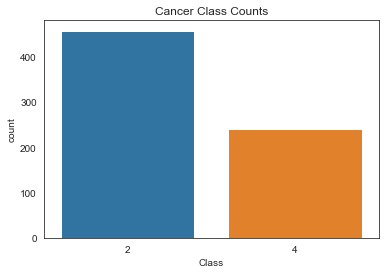

2    458
4    241
Name: Class, dtype: int64

In [5]:
# View value counts.
sns.countplot('Class', data=cancer)
plt.title('Cancer Class Counts')
plt.show()
pd.value_counts(cancer['Class'])

In [6]:
# Let's check for missing data.
cancer.isnull().sum()

Code             0
Clump_Thick      0
Unif_Size        0
Unif_Shape       0
Marg_Adh         0
Sng_Epi_Size     0
Bare_Nuclei     16
Bland_Chrom      0
Norm_Nuclei      0
Mitoses          0
Class            0
dtype: int64

In [7]:
# There are 16 missing values, so let's get rid of them.
cancer.dropna(subset=['Bare_Nuclei'], inplace=True)
cancer.isnull().sum()

Code            0
Clump_Thick     0
Unif_Size       0
Unif_Shape      0
Marg_Adh        0
Sng_Epi_Size    0
Bare_Nuclei     0
Bland_Chrom     0
Norm_Nuclei     0
Mitoses         0
Class           0
dtype: int64

4    350
2    350
Name: Class, dtype: int64

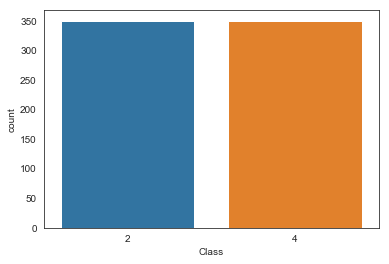

In [8]:
# Let's resample the data.
from sklearn.utils import resample
# Separate majority and minority classes.
benign = cancer[cancer.Class==2]
malignant = cancer[cancer.Class==4]

# Upsample minority class.
malignant_upsampled = resample(malignant,
                               replace=True,
                               n_samples=350,
                               random_state=15)

# Downsample majority class.
benign_downsampled = resample(benign,
                              replace=True,
                              n_samples=350,
                              random_state=15)

# Combine upsampled minority class and downsampled majority class.
cancer_sampled = pd.concat([malignant_upsampled, benign_downsampled])

# Display new class counts.
sns.countplot('Class', data=cancer_sampled)
cancer_sampled.Class.value_counts()

In [9]:
cancer_sampled.describe()

,Code,Clump_Thick,Unif_Size,Unif_Shape,Marg_Adh,Sng_Epi_Size,Bare_Nuclei,Bland_Chrom,Norm_Nuclei,Mitoses,Class
count,700.000,700.000,700.000,700.000,700.000,700.000,700.000,700.000,700.000,700.000,700.000
mean,1089106.131,5.043,4.039,4.150,3.613,3.831,4.480,4.050,3.503,1.843,3.000
std,777442.795,2.923,3.433,3.321,3.217,2.488,3.957,2.673,3.352,2.056,1.001
min,63375.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000
25%,873549.000,3.000,1.000,1.000,1.000,2.000,1.000,2.000,1.000,1.000,2.000
50%,1171710.000,5.000,3.000,3.000,2.000,3.000,2.000,3.000,1.000,1.000,3.000
75%,1241035.000,8.000,7.000,7.000,6.000,5.000,10.000,7.000,6.000,1.000,4.000
max,13454352.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,4.000


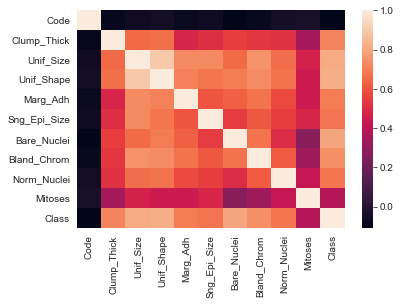

In [10]:
# Run heatmap to check for variable correlations.
sns.heatmap(cancer_sampled.corr())

In [11]:
# Split data into classes and training groups.
X = cancer_sampled.drop(['Class'], 1)
y = cancer_sampled.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

After attempting to run the Naive Bayes model, a ValueError occured regarding turning a string to a float (?).  After looking at the data set documentation, there are sixteen missing values that are represented by a '?'.  We will need to eliminate these values.

After addressing the null values, I then realized that I need to do some preprocessing (Naive Bayes cross-validation scores averaged 47.29%).  Let's run PCA.

In [20]:
# Set up and run PCA.
pca = PCA(n_components=10)
pca.fit(X)
X = pca.transform(X)

# Re-split data into classes and training groups with PCA.
X = cancer_sampled.drop(['Class'], 1)
y = cancer_sampled['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

print('Percentage of total variance explained by each component:\n', pca.explained_variance_ratio_)

Percentage of total variance explained by each component:
 [1.00000000e+00 9.48246365e-11 1.17322962e-11 8.13940485e-12
 7.62333777e-12 5.35261648e-12 5.09649591e-12 3.84335705e-12
 3.32960278e-12 1.74912176e-12]


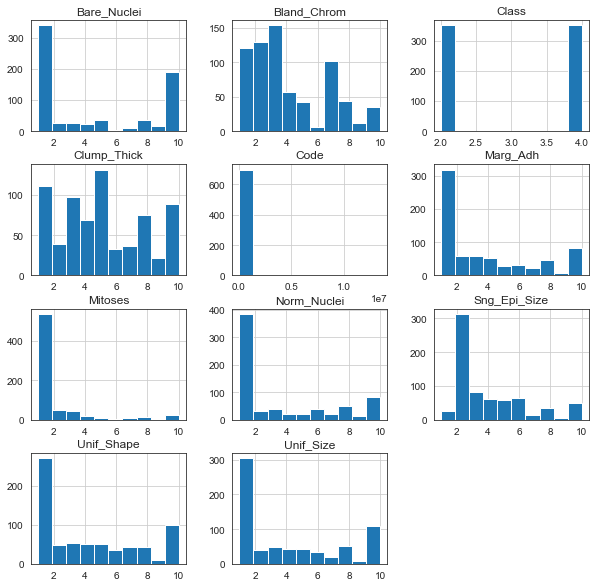

In [21]:
# Visualize the data.
hist = cancer_sampled.hist(bins=10,figsize =(10,10))

In [22]:
# Drop 'Code' column for better view of relevant data.
cancer_box = cancer_sampled.drop(['Code'], 1)

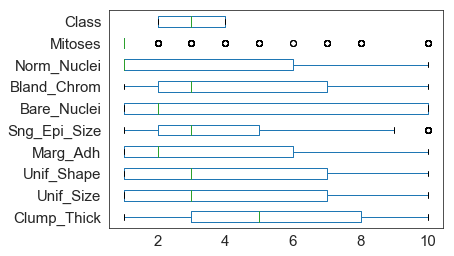

In [23]:
# Visualize outliers/deviations.
boxplot = cancer_box.boxplot(grid=False, vert=False,fontsize=15)

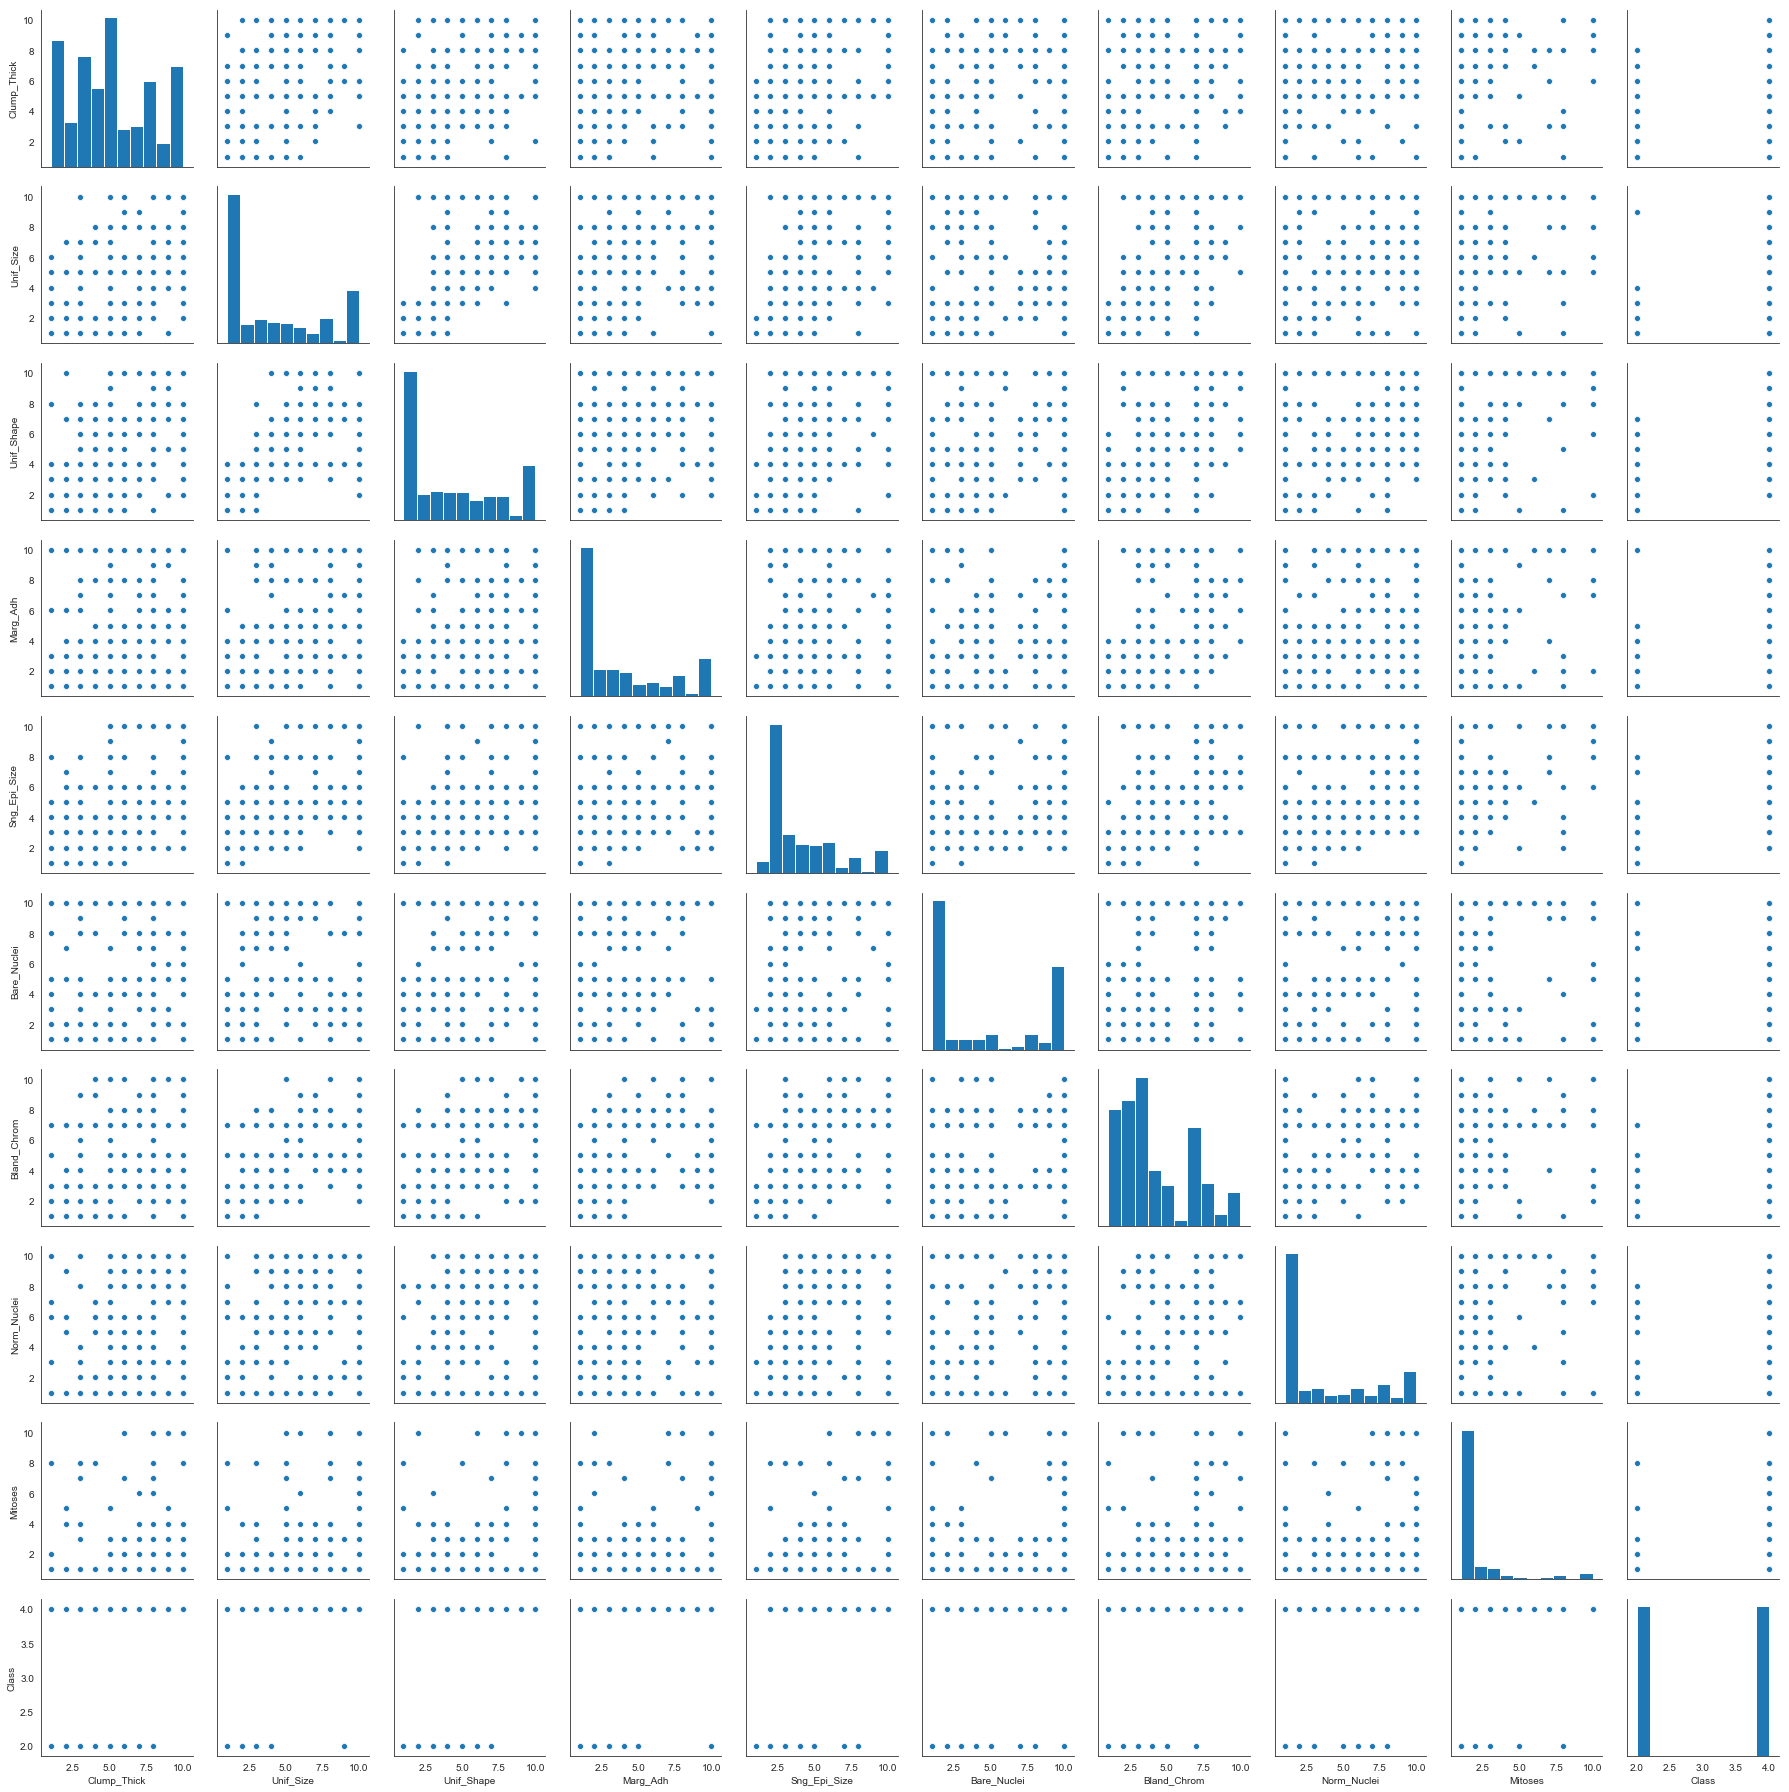

In [24]:
# Pairplot for correlations.
g = sns.pairplot(cancer_box)

In [39]:
np.reshape(y, 700, 1)


(700, 10)

In [40]:
y.shape

(700,)

In [41]:
X.shape

(700, 10)

In [42]:
# Naive Bayes.
gnb = GaussianNB()
# Fit the model.
gnb.fit(X_train, y_train)
print(gnb)
y_pred_gnb = gnb.predict(X)
# Accuracy score.
accuracy_score(y_test, y_pred_gnb)
# Cross-validation.
gnb_score = cross_val_score(gnb, X, y, cv=10)
print('Cross-Validation Scores: {}'.format(gnb_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(gnb_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_gnb))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_gnb))

GaussianNB(priors=None, var_smoothing=1e-09)


ValueError: Found input variables with inconsistent numbers of samples: [175, 700]

In [30]:
X.shape

(700, 10)

In [ ]:
# Build the KNN model.
knn = neighbors.KNeighborsClassifier(n_neighbors=7)
# Fit the model.
knn.fit(X_train, y_train)
print(knn)
y_pred_knn = knn.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_knn)
# Cross-validation.
knn_score = cross_val_score(knn, X, y, cv=10)
print('Cross-Validation Scores: {:.2%}'.format(knn_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(knn_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_knn))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_knn))